In [12]:
from cmath import tanh
from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

print(torch.__version__)


1.10.2


In [13]:

# 对输入数据做标准化（-1，1）
transform = transforms.Compose(
    [transforms.ToTensor(), # 0-1归一化，设置图片channel、high、width
    transforms.Normalize(0.5, 0.5)
    ]
)

train_ds = torchvision.datasets.MNIST('data', True, transform, download=True)

dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

imgs, _ = next(iter(dataloader))
print(imgs.shape)

torch.Size([64, 1, 28, 28])


In [14]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        imgs = self.main(x)
        imgs = imgs.view(-1, 28, 28, 1)
        return imgs

class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.main(x)
    

In [15]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = Generator().to(device)
dis = Discriminator().to(device)

g_optim = torch.optim.Adam(gen.parameters(), lr = 0.0001)
d_optim = torch.optim.Adam(dis.parameters(), lr = 0.0001)

loss_fn = torch.nn.BCELoss()

def gen_img_plot(model, epoch, test_input):
    pred = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((pred[i] + 1) / 2)
        plt.axis('off')
    plt.show()

epoch: 0


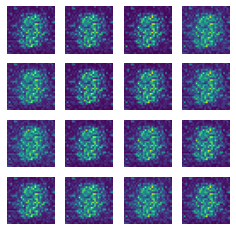

epoch: 1


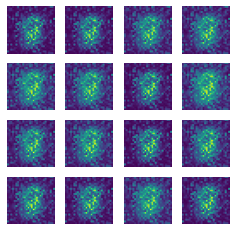

epoch: 2


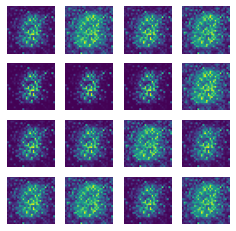

epoch: 3


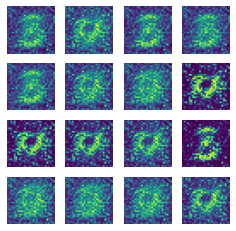

epoch: 4


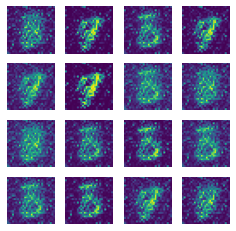

epoch: 5


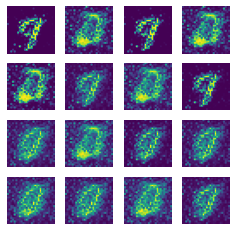

epoch: 6


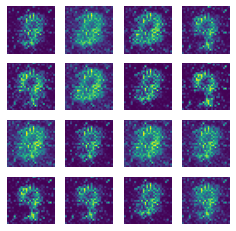

epoch: 7


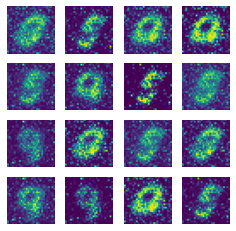

epoch: 8


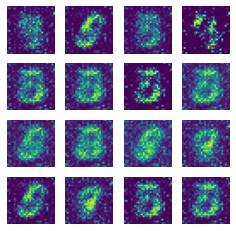

epoch: 9


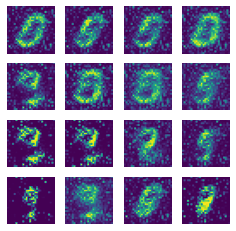

epoch: 10


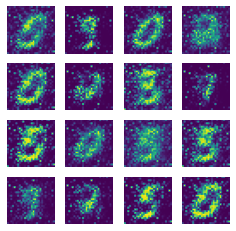

epoch: 11


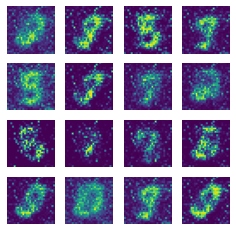

epoch: 12


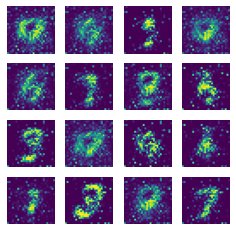

epoch: 13


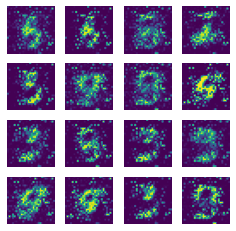

epoch: 14


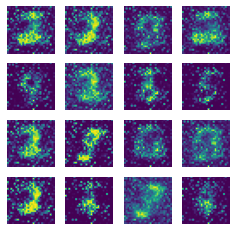

epoch: 15


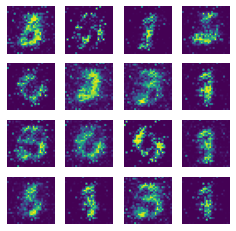

epoch: 16


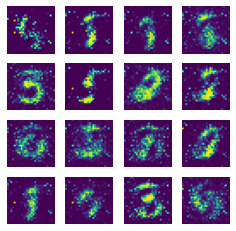

epoch: 17


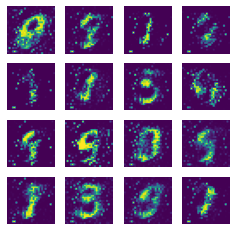

epoch: 18


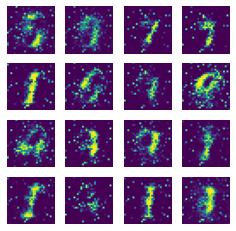

epoch: 19


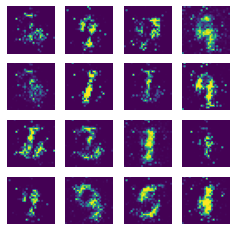

epoch: 20


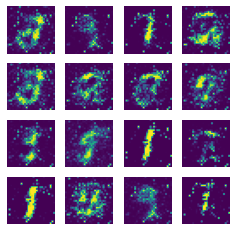

epoch: 21


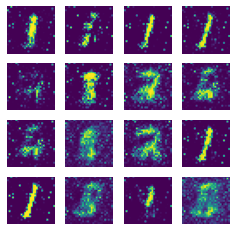

epoch: 22


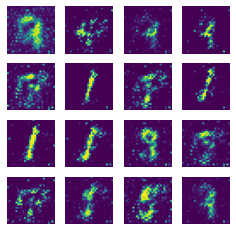

epoch: 23


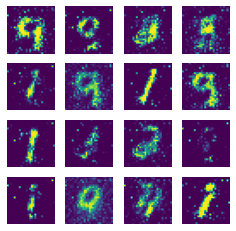

epoch: 24


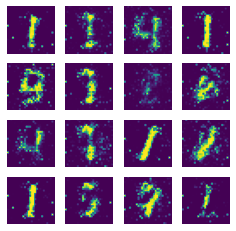

epoch: 25


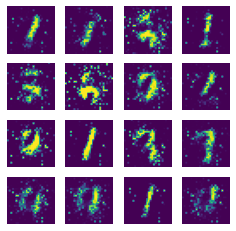

epoch: 26


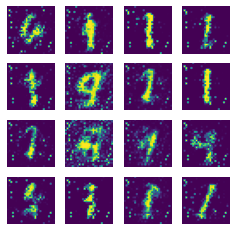

epoch: 27


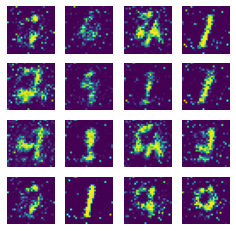

epoch: 28


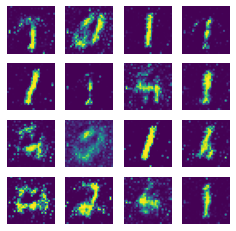

epoch: 29


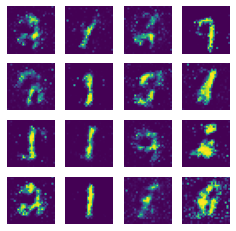

epoch: 30


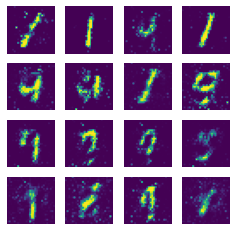

epoch: 31


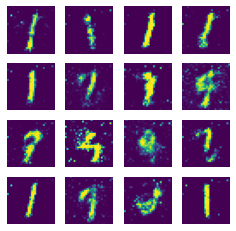

epoch: 32


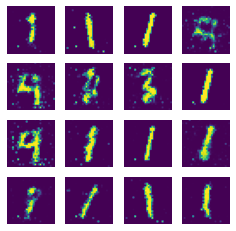

epoch: 33


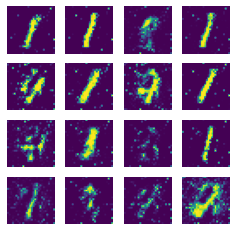

epoch: 34


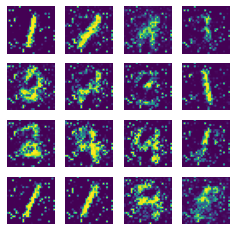

epoch: 35


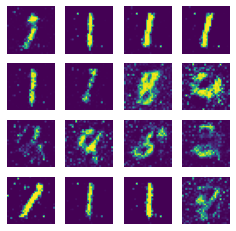

In [ ]:


D_loss = []
G_loss = []

for epoch in range(100):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    for step, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        size = imgs.size(0)
        random_noise = torch.randn(size, 100, device=device)


        d_optim.zero_grad()
        real_output = dis(imgs)
        d_real_loss = loss_fn(real_output, torch.ones_like(real_output))
        d_real_loss.backward()

        gen_imgs = gen(random_noise)
        fake_output = dis(gen_imgs.detach())
        d_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output))
        d_fake_loss.backward()

        d_loss = d_real_loss + d_fake_loss
        d_optim.step()

        g_optim.zero_grad()
        fake_output = dis(gen_imgs)
        g_loss = loss_fn(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_optim.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss

    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print(f'epoch: {epoch}')
        test_input = torch.randn(16, 100, device=device)
        gen_img_plot(gen, epoch, test_input)
